In [2]:
import re, nltk, spacy, string
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import numpy as np

import fasttext
from manual_spellchecker import spell_checker
import gensim
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
import wordcloud

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('.../text_data.csv')
df.head()

,review,voted_up
0,Fall Guys is a chill and fun game but it rea...,True
1,"I gave a little Hug to a player, he stared bac...",True
2,I'd reccomend it so much i'd buy it for you,True
3,you can hug people,True
4,"When I was a little boy, I liked to see the Wi...",True


In [4]:
df.info()

&lt;class &#39;pandas.core.frame.DataFrame&#39;&gt;
RangeIndex: 14252 entries, 0 to 14251
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   review    14242 non-null  object
 1   voted_up  14252 non-null  bool  
dtypes: bool(1), object(1)
memory usage: 125.4+ KB


In [5]:
df.review=df.review.astype(str)

In [6]:
df

,review,voted_up
0,Fall Guys is a chill and fun game but it rea...,True
1,"I gave a little Hug to a player, he stared bac...",True
2,I'd reccomend it so much i'd buy it for you,True
3,you can hug people,True
4,"When I was a little boy, I liked to see the Wi...",True
...,...,...
14247,Well made game that i cant get enough of! Many...,True
14248,very fun and competitive especially with frien...,True
14249,This game is extremely fun and a nice break fr...,True
14250,Fun to play & they keep working on this game,True


Text(0.5, 1.0, &#39;Recommended and Not Recommended Count&#39;)

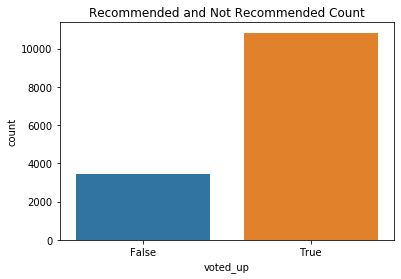

In [7]:
sns.countplot('voted_up',data= df)
plt.title('Recommended and Not Recommended Count')

In [18]:
df['voted_up'].value_counts(normalize = True).round(2)

True     0.76
False    0.24
Name: voted_up, dtype: float64

In [9]:
df['Length'] = df['review'].apply(lambda x : len(x.split()))

In [10]:
df

,review,voted_up,Length
0,Fall Guys is a chill and fun game but it rea...,True,39
1,"I gave a little Hug to a player, he stared bac...",True,40
2,I'd reccomend it so much i'd buy it for you,True,10
3,you can hug people,True,4
4,"When I was a little boy, I liked to see the Wi...",True,37
...,...,...,...
14247,Well made game that i cant get enough of! Many...,True,55
14248,very fun and competitive especially with frien...,True,13
14249,This game is extremely fun and a nice break fr...,True,40
14250,Fun to play & they keep working on this game,True,10


In [11]:
yrecc_length = df[df['voted_up'] == True]
nrecc_length = df[df['voted_up'] == False]

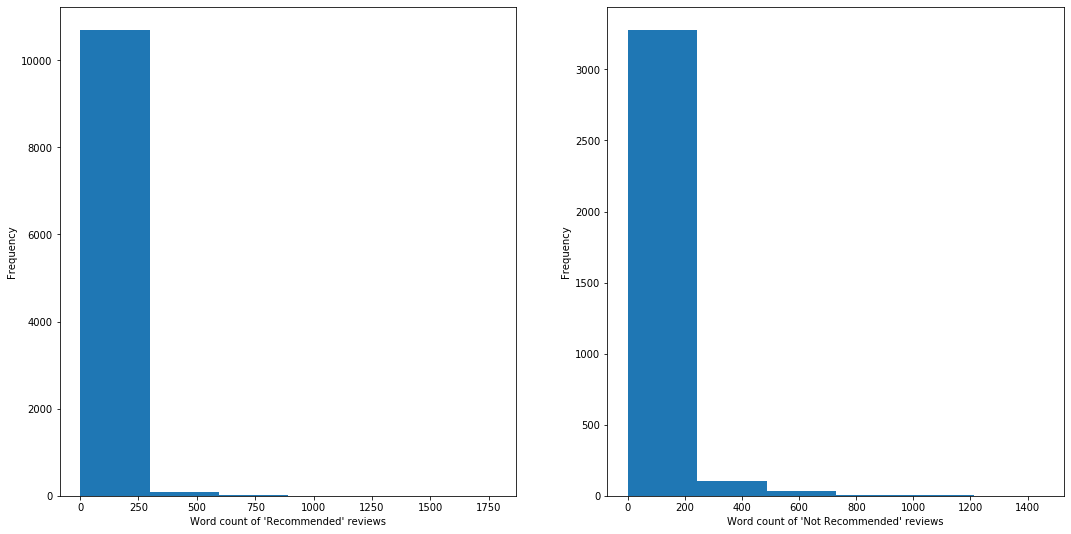

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,9))

ax1.hist(yrecc_length['Length'].values,bins=6)
ax1.set(xlabel='Word count of \'Recommended\' reviews',ylabel='Frequency')
ax2.hist(nrecc_length['Length'].values,bins=6)
ax2.set(xlabel='Word count of \'Not Recommended\' reviews',ylabel='Frequency')
plt.show()

In [16]:
yrecc_length.describe()

,Length
count,10821.000000
mean,27.883837
std,70.030733
min,1.000000
25%,3.000000
50%,9.000000
75%,24.000000
max,1778.000000


In [17]:
nrecc_length.describe()

,Length
count,3431.000000
mean,60.698047
std,107.341942
min,1.000000
25%,9.500000
50%,25.000000
75%,65.000000
max,1455.000000


In [6]:
df_text = df[['review', 'voted_up']]

## Cleaning Text

In [7]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

df_text['clean_1'] =  df_text['review'].apply(lambda x: clean_text(x))

In [46]:
df_text

,review,voted_up,clean_1
0,Fall Guys is a chill and fun game but it rea...,True,fall guys is a chill and fun game but it rea...
1,"I gave a little Hug to a player, he stared bac...",True,i gave a little hug to a player he stared back...
2,I'd reccomend it so much i'd buy it for you,True,id reccomend it so much id buy it for you
3,you can hug people,True,you can hug people
4,"When I was a little boy, I liked to see the Wi...",True,when i was a little boy i liked to see the wip...
...,...,...,...
14247,Well made game that i cant get enough of! Many...,True,well made game that i cant get enough of many ...
14248,very fun and competitive especially with frien...,True,very fun and competitive especially with frien...
14249,This game is extremely fun and a nice break fr...,True,this game is extremely fun and a nice break fr...
14250,Fun to play & they keep working on this game,True,fun to play they keep working on this game


In [8]:
df_text = df_text.replace('\n',' ', regex=True)

In [48]:
df_text

,review,voted_up,clean_1
0,Fall Guys is a chill and fun game but it rea...,True,fall guys is a chill and fun game but it rea...
1,"I gave a little Hug to a player, he stared bac...",True,i gave a little hug to a player he stared back...
2,I'd reccomend it so much i'd buy it for you,True,id reccomend it so much id buy it for you
3,you can hug people,True,you can hug people
4,"When I was a little boy, I liked to see the Wi...",True,when i was a little boy i liked to see the wip...
...,...,...,...
14247,Well made game that i cant get enough of! Many...,True,well made game that i cant get enough of many ...
14248,very fun and competitive especially with frien...,True,very fun and competitive especially with frien...
14249,This game is extremely fun and a nice break fr...,True,this game is extremely fun and a nice break fr...
14250,Fun to play & they keep working on this game,True,fun to play they keep working on this game


In [9]:
#categorize reviews' language using fasttext
pretrained_model = "lid.176.bin" 
model = fasttext.load_model(pretrained_model)

langs = []
for sent in df_text['clean_1']:
    lang = model.predict(sent)[0]
    langs.append(str(lang)[11:13])

df_text['langs'] = langs

df_text

,review,voted_up,clean_1,langs
0,Fall Guys is a chill and fun game but it rea...,True,fall guys is a chill and fun game but it rea...,en
1,"I gave a little Hug to a player, he stared bac...",True,i gave a little hug to a player he stared back...,en
2,I'd reccomend it so much i'd buy it for you,True,id reccomend it so much id buy it for you,en
3,you can hug people,True,you can hug people,en
4,"When I was a little boy, I liked to see the Wi...",True,when i was a little boy i liked to see the wip...,en
...,...,...,...,...
14247,Well made game that i cant get enough of! Many...,True,well made game that i cant get enough of many ...,en
14248,very fun and competitive especially with frien...,True,very fun and competitive especially with frien...,en
14249,This game is extremely fun and a nice break fr...,True,this game is extremely fun and a nice break fr...,en
14250,Fun to play & they keep working on this game,True,fun to play they keep working on this game,en


In [50]:
df_text.langs.unique()

array([&#39;en&#39;, &#39;pl&#39;, &#39;tr&#39;, &#39;id&#39;, &#39;zh&#39;, &#39;ja&#39;, &#39;ar&#39;, &#39;es&#39;, &#39;nl&#39;, &#39;wa&#39;, &#39;it&#39;,
       &#39;ru&#39;, &#39;ko&#39;, &#39;de&#39;, &#39;pt&#39;, &#39;fr&#39;, &#39;da&#39;, &#39;ca&#39;, &#39;nn&#39;, &#39;cs&#39;, &#39;hu&#39;, &#39;bg&#39;,
       &#39;bn&#39;, &#39;su&#39;, &#39;sk&#39;, &#39;no&#39;, &#39;bh&#39;, &#39;th&#39;, &#39;ce&#39;, &#39;eo&#39;, &#39;sr&#39;, &#39;mi&#39;, &#39;io&#39;,
       &#39;sl&#39;, &#39;uk&#39;, &#39;lt&#39;, &#39;mk&#39;, &#39;he&#39;, &#39;ie&#39;, &#39;nd&#39;, &#39;ro&#39;, &#39;sv&#39;, &#39;et&#39;, &#39;ht&#39;,
       &#39;az&#39;, &#39;si&#39;, &#39;vi&#39;, &#39;fi&#39;, &#39;gl&#39;, &#39;na&#39;, &#39;lv&#39;, &#39;la&#39;, &#39;jv&#39;, &#39;sh&#39;, &#39;ne&#39;,
       &#39;is&#39;, &#39;ms&#39;, &#39;hi&#39;, &#39;lb&#39;, &#39;uz&#39;, &#39;ur&#39;, &#39;hr&#39;, &#39;vo&#39;, &#39;bs&#39;, &#39;hs&#39;, &#39;sw&#39;,
       &#39;gd&#39;, &#39;km&#39;,

In [51]:
df_text['langs'].value_counts()

en    13095
de      321
es       96
fr       84
pt       78
      ...  
ur        1
bs        1
tl        1
gl        1
hi        1
Name: langs, Length: 74, dtype: int64

In [10]:
df_text = df_text[df_text['langs'] == 'en']

In [55]:
df_text.shape

(13095, 4)

In [11]:
df_text.reset_index(inplace= True, drop= True)

In [12]:
df_text.drop('langs', axis=1, inplace=True )
df_text

,review,voted_up,clean_1
0,Fall Guys is a chill and fun game but it rea...,True,fall guys is a chill and fun game but it rea...
1,"I gave a little Hug to a player, he stared bac...",True,i gave a little hug to a player he stared back...
2,I'd reccomend it so much i'd buy it for you,True,id reccomend it so much id buy it for you
3,you can hug people,True,you can hug people
4,"When I was a little boy, I liked to see the Wi...",True,when i was a little boy i liked to see the wip...
...,...,...,...
13090,Well made game that i cant get enough of! Many...,True,well made game that i cant get enough of many ...
13091,very fun and competitive especially with frien...,True,very fun and competitive especially with frien...
13092,This game is extremely fun and a nice break fr...,True,this game is extremely fun and a nice break fr...
13093,Fun to play & they keep working on this game,True,fun to play they keep working on this game


In [58]:
ob = spell_checker(df_text, "clean_1")
ob.spell_check()


Analyzing suspected errors




Total suspected errors =  21906


In [59]:
ob.get_all_errors()

[&#39;improvementsworkshop&#39;,
 &#39;reccomend&#39;,
 &#39;wipeout&#39;,
 &#39;tv&#39;,
 &#39;mediatonic&#39;,
 &#39;thats&#39;,
 &#39;funnychaotic&#39;,
 &#39;repetetive&#39;,
 &#39;minigames&#39;,
 &#39;im&#39;,
 &#39;minigame&#39;,
 &#39;arent&#39;,
 &#39;hexagone&#39;,
 &#39;minigame&#39;,
 &#39;youd&#39;,
 &#39;microtransactions&#39;,
 &#39;isnt&#39;,
 &#39;gordon&#39;,
 &#39;minigames&#39;,
 &#39;indepth&#39;,
 &#39;minigame&#39;,
 &#39;thats&#39;,
 &#39;theres&#39;,
 &#39;lol&#39;,
 &#39;havent&#39;,
 &#39;youre&#39;,
 &#39;wouldnt&#39;,
 &#39;weve&#39;,
 &#39;thats&#39;,
 &#39;couldnt&#39;,
 &#39;devs&#39;,
 &#39;im&#39;,
 &#39;dont&#39;,
 &#39;devolverland&#39;,
 &#39;royale&#39;,
 &#39;colours&#39;,
 &#39;ive&#39;,
 &#39;mediatonic&#39;,
 &#39;dont&#39;,
 &#39;upupdate&#39;,
 &#39;im&#39;,
 &#39;mediatonic&#39;,
 &#39;levelled&#39;,
 &#39;havent&#39;,
 &#39;im&#39;,
 &#39;technicolour&#39;,
 &#39;theres&#39;,
 &#39;royale&#39;,
 &#39;thats&#39;,
 &#39;i’d&#39;,
 &#39;youre&

In [13]:
df_text[df_text['clean_1'].str.contains("español")]

,review,voted_up,clean_1
63,~ THIS REVIEW IS IN ENGLISH AND IN SPANISH ~~ ...,True,this review is in english and in spanish est...


In [14]:
df_text.drop(df_text.index[63], inplace= True)

In [15]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               u"\u2014"
                               u"\u2022"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [16]:
df_text['clean_1'] = df_text['clean_1'].apply(remove_emoji)

In [17]:
df_text.reset_index(inplace= True, drop= True)

In [66]:
df_text

,review,voted_up,clean_1
0,Fall Guys is a chill and fun game but it rea...,True,fall guys is a chill and fun game but it rea...
1,"I gave a little Hug to a player, he stared bac...",True,i gave a little hug to a player he stared back...
2,I'd reccomend it so much i'd buy it for you,True,id reccomend it so much id buy it for you
3,you can hug people,True,you can hug people
4,"When I was a little boy, I liked to see the Wi...",True,when i was a little boy i liked to see the wip...
...,...,...,...
13089,Well made game that i cant get enough of! Many...,True,well made game that i cant get enough of many ...
13090,very fun and competitive especially with frien...,True,very fun and competitive especially with frien...
13091,This game is extremely fun and a nice break fr...,True,this game is extremely fun and a nice break fr...
13092,Fun to play & they keep working on this game,True,fun to play they keep working on this game


In [18]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [19]:
def lemmatizer(text):        
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

In [20]:
df_text["review_lemmatize"] =  df_text.apply(lambda x: lemmatizer(x['clean_1']), axis=1)

In [70]:
df_text

,review,voted_up,clean_1,review_lemmatize
0,Fall Guys is a chill and fun game but it rea...,True,fall guys is a chill and fun game but it rea...,fall guy be a chill and fun game but -PRON...
1,"I gave a little Hug to a player, he stared bac...",True,i gave a little hug to a player he stared back...,i give a little hug to a player -PRON- stare b...
2,I'd reccomend it so much i'd buy it for you,True,id reccomend it so much id buy it for you,-PRON- d reccomend -PRON- so much -PRON- d buy...
3,you can hug people,True,you can hug people,-PRON- can hug people
4,"When I was a little boy, I liked to see the Wi...",True,when i was a little boy i liked to see the wip...,when i be a little boy i like to see the wipeo...
...,...,...,...,...
13089,Well made game that i cant get enough of! Many...,True,well made game that i cant get enough of many ...,well make game that i can not get enough of ma...
13090,very fun and competitive especially with frien...,True,very fun and competitive especially with frien...,very fun and competitive especially with frien...
13091,This game is extremely fun and a nice break fr...,True,this game is extremely fun and a nice break fr...,this game be extremely fun and a nice break fr...
13092,Fun to play & they keep working on this game,True,fun to play they keep working on this game,fun to play -PRON- keep work on this game


In [21]:
df_text = df_text.replace('-PRON-','', regex=True)

In [72]:
df_text

,review,voted_up,clean_1,review_lemmatize
0,Fall Guys is a chill and fun game but it rea...,True,fall guys is a chill and fun game but it rea...,fall guy be a chill and fun game but real...
1,"I gave a little Hug to a player, he stared bac...",True,i gave a little hug to a player he stared back...,i give a little hug to a player stare back at...
2,I'd reccomend it so much i'd buy it for you,True,id reccomend it so much id buy it for you,d reccomend so much d buy for
3,you can hug people,True,you can hug people,can hug people
4,"When I was a little boy, I liked to see the Wi...",True,when i was a little boy i liked to see the wip...,when i be a little boy i like to see the wipeo...
...,...,...,...,...
13089,Well made game that i cant get enough of! Many...,True,well made game that i cant get enough of many ...,well make game that i can not get enough of ma...
13090,very fun and competitive especially with frien...,True,very fun and competitive especially with frien...,very fun and competitive especially with frien...
13091,This game is extremely fun and a nice break fr...,True,this game is extremely fun and a nice break fr...,this game be extremely fun and a nice break fr...
13092,Fun to play & they keep working on this game,True,fun to play they keep working on this game,fun to play keep work on this game


In [22]:
df_text['tokenized'] = df_text['review_lemmatize'].apply(word_tokenize)
df_text.head()

,review,voted_up,clean_1,review_lemmatize,tokenized
0,Fall Guys is a chill and fun game but it rea...,True,fall guys is a chill and fun game but it rea...,fall guy be a chill and fun game but real...,"[fall, guy, be, a, chill, and, fun, game, but,..."
1,"I gave a little Hug to a player, he stared bac...",True,i gave a little hug to a player he stared back...,i give a little hug to a player stare back at...,"[i, give, a, little, hug, to, a, player, stare..."
2,I'd reccomend it so much i'd buy it for you,True,id reccomend it so much id buy it for you,d reccomend so much d buy for,"[d, reccomend, so, much, d, buy, for]"
3,you can hug people,True,you can hug people,can hug people,"[can, hug, people]"
4,"When I was a little boy, I liked to see the Wi...",True,when i was a little boy i liked to see the wip...,when i be a little boy i like to see the wipeo...,"[when, i, be, a, little, boy, i, like, to, see..."


In [23]:
all_stopwords = stopwords.words('english')

In [24]:
df_text['clean_token'] = df_text['tokenized'].apply(lambda x: [word for word in x if word not in all_stopwords])
df_text.head()

,review,voted_up,clean_1,review_lemmatize,tokenized,clean_token
0,Fall Guys is a chill and fun game but it rea...,True,fall guys is a chill and fun game but it rea...,fall guy be a chill and fun game but real...,"[fall, guy, be, a, chill, and, fun, game, but,...","[fall, guy, chill, fun, game, really, need, se..."
1,"I gave a little Hug to a player, he stared bac...",True,i gave a little hug to a player he stared back...,i give a little hug to a player stare back at...,"[i, give, a, little, hug, to, a, player, stare...","[give, little, hug, player, stare, back, secon..."
2,I'd reccomend it so much i'd buy it for you,True,id reccomend it so much id buy it for you,d reccomend so much d buy for,"[d, reccomend, so, much, d, buy, for]","[reccomend, much, buy]"
3,you can hug people,True,you can hug people,can hug people,"[can, hug, people]","[hug, people]"
4,"When I was a little boy, I liked to see the Wi...",True,when i was a little boy i liked to see the wip...,when i be a little boy i like to see the wipeo...,"[when, i, be, a, little, boy, i, like, to, see...","[little, boy, like, see, wipeout, tv, always, ..."


In [25]:
df_text['clean_str'] = [' '.join(map(str, l)) for l in df_text['clean_token']]
df_text

,review,voted_up,clean_1,review_lemmatize,tokenized,clean_token,clean_str
0,Fall Guys is a chill and fun game but it rea...,True,fall guys is a chill and fun game but it rea...,fall guy be a chill and fun game but real...,"[fall, guy, be, a, chill, and, fun, game, but,...","[fall, guy, chill, fun, game, really, need, se...",fall guy chill fun game really need server imp...
1,"I gave a little Hug to a player, he stared bac...",True,i gave a little hug to a player he stared back...,i give a little hug to a player stare back at...,"[i, give, a, little, hug, to, a, player, stare...","[give, little, hug, player, stare, back, secon...",give little hug player stare back second jump ...
2,I'd reccomend it so much i'd buy it for you,True,id reccomend it so much id buy it for you,d reccomend so much d buy for,"[d, reccomend, so, much, d, buy, for]","[reccomend, much, buy]",reccomend much buy
3,you can hug people,True,you can hug people,can hug people,"[can, hug, people]","[hug, people]",hug people
4,"When I was a little boy, I liked to see the Wi...",True,when i was a little boy i liked to see the wip...,when i be a little boy i like to see the wipeo...,"[when, i, be, a, little, boy, i, like, to, see...","[little, boy, like, see, wipeout, tv, always, ...",little boy like see wipeout tv always dream ta...
...,...,...,...,...,...,...,...
13089,Well made game that i cant get enough of! Many...,True,well made game that i cant get enough of many ...,well make game that i can not get enough of ma...,"[well, make, game, that, i, can, not, get, eno...","[well, make, game, get, enough, many, way, dif...",well make game get enough many way differentia...
13090,very fun and competitive especially with frien...,True,very fun and competitive especially with frien...,very fun and competitive especially with frien...,"[very, fun, and, competitive, especially, with...","[fun, competitive, especially, friend, recomme...",fun competitive especially friend recommend bu...
13091,This game is extremely fun and a nice break fr...,True,this game is extremely fun and a nice break fr...,this game be extremely fun and a nice break fr...,"[this, game, be, extremely, fun, and, a, nice,...","[game, extremely, fun, nice, break, usual, dro...",game extremely fun nice break usual drop loot ...
13092,Fun to play & they keep working on this game,True,fun to play they keep working on this game,fun to play keep work on this game,"[fun, to, play, keep, work, on, this, game]","[fun, play, keep, work, game]",fun play keep work game


In [26]:
df_clean = df_text[['voted_up', 'clean_token', 'clean_str']]
df_clean

,voted_up,clean_token,clean_str
0,True,"[fall, guy, chill, fun, game, really, need, se...",fall guy chill fun game really need server imp...
1,True,"[give, little, hug, player, stare, back, secon...",give little hug player stare back second jump ...
2,True,"[reccomend, much, buy]",reccomend much buy
3,True,"[hug, people]",hug people
4,True,"[little, boy, like, see, wipeout, tv, always, ...",little boy like see wipeout tv always dream ta...
...,...,...,...
13089,True,"[well, make, game, get, enough, many, way, dif...",well make game get enough many way differentia...
13090,True,"[fun, competitive, especially, friend, recomme...",fun competitive especially friend recommend bu...
13091,True,"[game, extremely, fun, nice, break, usual, dro...",game extremely fun nice break usual drop loot ...
13092,True,"[fun, play, keep, work, game]",fun play keep work game


## EDA Clean Text

### Top Unigram

In [94]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df_clean['clean_str'], 21)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

In [95]:
df2

,unigram,count
0,game,18203
1,fun,6291
2,play,4485
3,good,3009
4,fall,2350
5,like,2127
6,time,1992
7,friend,1944
8,team,1936
9,make,1791


In [97]:
fig = go.Figure([go.Bar(x=df2['unigram'], y=df2['count'])])
fig.update_layout(title=go.layout.Title(text="Top 20 unigrams in the review text"))
fig.show()

In [96]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df_clean['clean_str'], 21)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

In [98]:
df3

,bigram,count
0,fall guy,1283
1,fun game,1184
2,good game,1009
3,game play,763
4,team game,759
5,game fun,738
6,play game,642
7,play friend,604
8,battle royale,576
9,game good,512


In [99]:
fig = go.Figure([go.Bar(x=df2['bigram'], y=df3['count'])])
fig.update_layout(title=go.layout.Title(text="Top 20 bigrams in the review"))
fig.show()

In [57]:
word_list = []
for i in df_clean['clean_token']:
    word_list.extend(i)

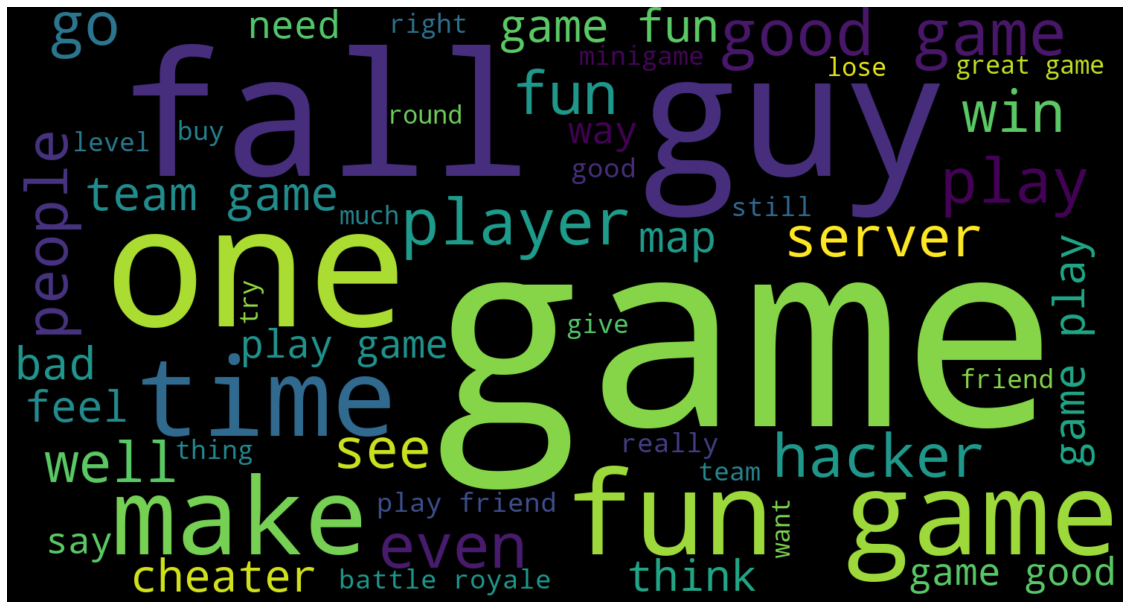

In [58]:
text = ' '.join(w for w in word_list)

# Create and generate a word cloud image
wcd = wordcloud.WordCloud(width = 1500, height=800, max_words = 50).generate(text)

# Display the generated image:
plt.figure(figsize=(20,15))
plt.imshow(wcd, interpolation='bilinear')
plt.axis("off")
plt.show()

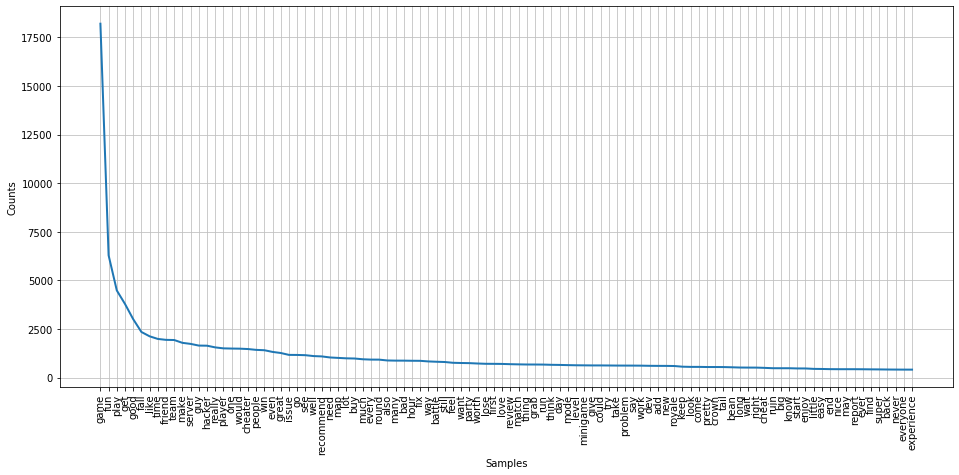

&lt;matplotlib.axes._subplots.AxesSubplot at 0x249c3b23508&gt;

In [59]:
wordfreq = nltk.FreqDist(word_list)
# Print the most common words.
plt.figure(figsize=(16,7))
wordfreq_2gram.plot(100,cumulative=False)

In [63]:
df_clean

,voted_up,clean_token,clean_str
0,True,"[fall, guy, chill, fun, game, really, need, se...",fall guy chill fun game really need server imp...
1,True,"[give, little, hug, player, stare, back, secon...",give little hug player stare back second jump ...
2,True,"[reccomend, much, buy]",reccomend much buy
3,True,"[hug, people]",hug people
4,True,"[little, boy, like, see, wipeout, tv, always, ...",little boy like see wipeout tv always dream ta...
...,...,...,...
13089,True,"[well, make, game, get, enough, many, way, dif...",well make game get enough many way differentia...
13090,True,"[fun, competitive, especially, friend, recomme...",fun competitive especially friend recommend bu...
13091,True,"[game, extremely, fun, nice, break, usual, dro...",game extremely fun nice break usual drop loot ...
13092,True,"[fun, play, keep, work, game]",fun play keep work game


In [64]:
df_clean.to_csv('.../clean_text.csv', index = False, encoding = 'utf-8')